Model

In [509]:
# Import libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

Settings

In [510]:
catalog_lunar_dir = "./data/lunar/data/training/catalogs/apollo12_catalog_GradeA_final.csv"
data_dir = "./data/lunar/data/training/data/Processed"
chunk_size = 10000

Enter Raw Test File Inof:


In [511]:
raw_data_dir = "./data/lunar/data/test/data/Filt_S16_GradeA"
file_name = "xa.s16.00.mhz.1977-06-02HR00_evid00255.csv"

Functions

In [512]:
#Process single lunar data

def process_lunar_data(catalog_path, data_dir, row_num, chunk_size):
    # Read the catalog file
    catalog_lunar = pd.read_csv(catalog_path)

    # Extract row and relevant data
    row = catalog_lunar.iloc[row_num]
    arrival_time = datetime.strptime(row["time_abs(%Y-%m-%dT%H:%M:%S.%f)"], '%Y-%m-%dT%H:%M:%S.%f')
    arrival_time_relative = row["time_rel(sec)"]
    test_filename = row.filename

    # Read the associated CSV file containing raw data
    csv_file = f'{data_dir}/{test_filename}.csv'
    raw_data = pd.read_csv(csv_file)

    # Initialize the results dataframe
    total_rows = raw_data.shape[0]
    results_df = pd.DataFrame(columns=["chunk", "label"])

    # Iterate over chunks of data
    start = 0
    while start < total_rows:
        end = min(start + chunk_size, total_rows)  # Handle case where we don't have a full chunk at the end
        chunk = raw_data.iloc[start:end]
        data_df = pd.DataFrame(chunk["time_rel(sec)"])

        # Check if arrival time is within the current chunk
        if arrival_time_relative >= data_df["time_rel(sec)"].values.min() and arrival_time_relative <= data_df["time_rel(sec)"].values.max():
            # Split chunk at the arrival_time_relative
            before_arrival = chunk[data_df["time_rel(sec)"] < arrival_time_relative]
            after_arrival = chunk[data_df["time_rel(sec)"] >= arrival_time_relative]

            # Add the part before arrival_time_relative with label 0
            if not before_arrival.empty:
                results_df = pd.concat([results_df, pd.DataFrame({"chunk": [before_arrival], "label": [0]})], ignore_index=True)

            # Add a chunk starting from the arrival_time_relative, ensure it has chunk_size rows
            after_start = after_arrival.index[0]  # Start from the first row after the arrival time
            after_end = min(after_start + chunk_size, total_rows)  # Ensure the chunk has exactly chunk_size rows
            after_chunk = raw_data.iloc[after_start:after_end]

            results_df = pd.concat([results_df, pd.DataFrame({"chunk": [after_chunk], "label": [1]})], ignore_index=True)

            # Move the start index beyond this chunk (chunk_size after the arrival time)
            start = after_end
        else:
            # If no arrival time in this chunk, label the entire chunk as 0
            results_df = pd.concat([results_df, pd.DataFrame({"chunk": [chunk], "label": [0]})], ignore_index=True)
            start += chunk_size  # Move to the next chunk

    # If there are remaining rows less than the chunk size, add them with the appropriate label
    if start < total_rows:
        remaining_chunk = raw_data.iloc[start:total_rows]
        remaining_label = 1 if arrival_time_relative >= remaining_chunk["time_rel(sec)"].values.min() else 0
        results_df = pd.concat([results_df, pd.DataFrame({"chunk": [remaining_chunk], "label": [remaining_label]})], ignore_index=True)

    return results_df







# Process entire catalog

def process_entire_catalog(catalog_dir, data_dir, chunk_size):
    try:
        catalog_lunar = pd.read_csv(catalog_dir)
        testing_df = pd.DataFrame(columns=["chunk", "label"])  # Initialize an empty dataframe to store results
        
        # Iterate over every row in the catalog
        for row_num in range(len(catalog_lunar)):
            # Process each row using process_lunar_data and append the result to testing_df
            results_df = process_lunar_data(catalog_dir, data_dir, row_num, chunk_size)
            testing_df = pd.concat([testing_df, results_df], ignore_index=True)
    
    except FileNotFoundError:
        print("File not found")
    
    return testing_df






# extracting the features

def extract_features_from_chunk(chunk):
    features = {}
    
    
    
    # Velocity features
    # features['mean_velocity'] = chunk["velocity(m/s)"].mean()
    
    # features['max_velocity'] = chunk["velocity(m/s)"].max()
    # features['min_velocity'] = chunk["velocity(m/s)"].min()
    # features['std_velocity'] = chunk["velocity(m/s)"].std()
    # features['range_velocity'] = features['max_velocity'] - features['min_velocity']
    
    # # Energy features
    # features['total_energy'] = (chunk["velocity(m/s)"] ** 2).sum()
     # # Frequency/Oscillation features (zero crossings)
    signs = np.sign(chunk["velocity(m/s)"])
    signs[signs == 0] = -1  # Treat zeros as negative to prevent false crossings

    # Find zero crossings
    zero_crossings = np.where(np.diff(signs))[0]

    # Calculate zero-crossing rate
    features['zero_crossing_rate'] = len(zero_crossings) / len(chunk)

    rms_velocity = np.sqrt(np.mean(chunk["velocity(m/s)"]**2))
    features["rms_velocity"] = rms_velocity
    


    mean_abs_velocity = np.mean(np.abs(chunk["velocity(m/s)"]))
    features["mean_abs_velocity"] = mean_abs_velocity
    
    total_energy = (chunk['velocity(m/s)'] ** 2).sum()
    features["total_energy"] = total_energy



   
    
    
    
    return features





# converting to suitable

def convert_to_polished_df(testing_df):
    polished_data = []

    for idx, row in testing_df.iterrows():
        chunk = row["chunk"]
        label = row["label"]
        
        # Extract statistical features from chunk
        features = extract_features_from_chunk(chunk)
        features['label'] = label  # Add the label for quake/no-quake
        
        # Append to polished data
        polished_data.append(features)

    # Convert to a new DataFrame
    polished_df = pd.DataFrame(polished_data)
    return polished_df





# Process raw input into ready for model to read
def process_raw_file_for_model(raw_data_dir, file_name, chunk_size):
    # Path to the CSV file
    csv_file = f"{raw_data_dir}/{file_name}"
    
    # Read the raw data from the CSV file
    raw_data = pd.read_csv(csv_file)
    total_rows = raw_data.shape[0]

    # Lists to store statistics for each chunk and the chunks themselves
    stats_list = []
    chunks_list = []  # List to store the chunks

    # Iterate over chunks of data in the file
    start = 0
    while start < total_rows:
        end = min(start + chunk_size, total_rows)
        chunk = raw_data.iloc[start:end]

        # Store the current chunk in the chunks list
        chunks_list.append(chunk)

        # Calculate statistical values from the chunk
        # mean_velocity = chunk['velocity(m/s)'].mean()
        
        # max_velocity = chunk['velocity(m/s)'].max()
        # min_velocity = chunk['velocity(m/s)'].min()
        # std_velocity = chunk['velocity(m/s)'].std()
        # range_velocity = max_velocity - min_velocity
        # total_energy = (chunk['velocity(m/s)'] ** 2).sum()
        # rms_velocity = (chunk['velocity(m/s)'] ** 2).mean() ** 0.5
        
        mean_abs_velocity = np.mean(np.abs(chunk['velocity(m/s)']))
        rms_velocity = np.sqrt(np.mean(chunk['velocity(m/s)'] ** 2))
        # Calculate zero crossing rate
        signs = np.sign(chunk["velocity(m/s)"])

        # Treat zeros as negative to avoid false zero crossings
        signs[signs == 0] = -1

        # Find zero crossings (where the sign changes)
        zero_crossings = np.where(np.diff(signs))[0]

        # Calculate the zero-crossing rate (normalized by the chunk length)
        zero_crossing_rate = len(zero_crossings) / len(chunk["velocity(m/s)"])  # Count of zero crossings

        total_energy = (chunk['velocity(m/s)'] ** 2).sum()


        # Add the calculated statistics to the stats list
        stats_list.append({
            # 'mean_velocity': mean_velocity,
            
            # 'max_velocity': max_velocity,
            # 'min_velocity': min_velocity,
            # 'std_velocity': std_velocity,
            # 'range_velocity': range_velocity,
            # 'total_energy': total_energy,
            # 'rms_velocity': rms_velocity,
            'zero_crossing_rate': zero_crossing_rate,
            "rms_velocity": rms_velocity,
            "mean_abs_velocity": mean_abs_velocity,
            "total_energy": total_energy
        })

        # Move to the next chunk
        start += chunk_size

    # Create DataFrames from the lists
    stats_df = pd.DataFrame(stats_list)  # DataFrame for statistics
    chunks_df = pd.DataFrame({'chunks': chunks_list})  # DataFrame for chunks

    return stats_df, chunks_df


# Plot Input Data

def plot_data(data_dir, file_name):
    
    test_filename = file_name
    csv_file = f'{data_dir}/{test_filename}'
    data = pd.read_csv(csv_file)

    csv_times = np.array(data["time_rel(sec)"].tolist())
    csv_velocity = np.array(data["velocity(m/s)"].tolist())

    # Plot the trace!
    fig,ax = plt.subplots(1,1,figsize=(10,3))
    ax.plot(csv_times,csv_velocity)
    # Make the plot pretty
    ax.set_xlim([min(csv_times),max(csv_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')
    

Training Data

In [513]:
testing_chunks = process_entire_catalog(catalog_lunar_dir, data_dir, chunk_size)
polished_df = convert_to_polished_df(testing_chunks)

label_counts = polished_df["label"].value_counts()
print(label_counts)

count_label_1 = label_counts.get(1, 0)

count_label_1

File not found
label
0    1143
1      20
Name: count, dtype: int64


20

In [514]:
polished_df

,zero_crossing_rate,rms_velocity,mean_abs_velocity,total_energy,label
0,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0
1,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0
2,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0
3,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0
4,0.0006,1.083622e-10,9.047974e-12,1.174236e-16,0
...,...,...,...,...,...
1158,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0
1159,0.0010,2.209631e-10,3.283871e-11,4.882469e-16,0
1160,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0
1161,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0


In [515]:
polished_df[polished_df["label"] == 1]

,zero_crossing_rate,rms_velocity,mean_abs_velocity,total_energy,label
49,0.2075,1.951190e-09,1.364715e-09,3.807142e-14,1
67,0.1261,9.920363e-10,5.183560e-10,9.841359e-15,1
165,0.1702,1.336456e-09,8.229786e-10,1.786114e-14,1
177,0.1730,1.563069e-09,9.755166e-10,2.443186e-14,1
267,0.1222,1.022953e-09,5.565886e-10,1.046433e-14,1
336,0.2300,3.653469e-09,2.638751e-09,1.334783e-13,1
396,0.2284,1.050084e-08,7.427873e-09,1.102676e-12,1
419,0.2282,4.356781e-09,3.227672e-09,1.898154e-13,1
493,0.1509,1.392531e-09,8.518570e-10,1.939141e-14,1
571,0.1500,1.058667e-09,5.975554e-10,1.120777e-14,1


Model Implementation

In [516]:
#Option 1 - Using LR

from sklearn.linear_model import LogisticRegression

# Split the dataset into features (X) and target labels (y)
X = polished_df.drop(columns=['label'])  # Features
y = polished_df['label']  # Target labels (1 for quake, 0 for non-quake)


# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize the Random Forest Classifier
clf = LogisticRegression( max_iter=1000, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))





Accuracy: 0.979381443298969
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       570
           1       0.00      0.00      0.00        12

    accuracy                           0.98       582
   macro avg       0.49      0.50      0.49       582
weighted avg       0.96      0.98      0.97       582



c:\Users\mirha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mirha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mirha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [517]:
# Option 2 - Balancing the data out more

df = polished_df

# Split the DataFrame into two separate DataFrames for each class
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

# Specify the number of majority class instances you want to keep
# Here we keep the same number as minority class instances
n_minority = len(df_minority)
df_majority_undersampled = df_majority.sample(n=n_minority, random_state=42)  # Randomly sample from majority class

# Combine the undersampled majority class with the minority class
df_balanced = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the DataFrame to mix class labels
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Now `df_balanced` is your new training dataset with a balanced class distribution

# Split the dataset into features (X) and target labels (y)
X = df_balanced.drop(columns=['label'])  # Features
y = df_balanced['label']  # Target labels (1 for quake, 0 for non-quake)


# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Classifier
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf2.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))




Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [518]:
# Option 3 - USED

# Split the dataset into features (X) and target labels (y)
X = polished_df.drop(columns=['label'])  # Features
y = polished_df['label']  # Target labels (1 for quake, 0 for non-quake)

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize the Random Forest Classifier
clf3 = RandomForestClassifier(class_weight="balanced", random_state=42)

# Train the model
clf3.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf3.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9828178694158075
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       570
           1       0.60      0.50      0.55        12

    accuracy                           0.98       582
   macro avg       0.79      0.75      0.77       582
weighted avg       0.98      0.98      0.98       582



In [519]:
f"{raw_data_dir}/{file_name}"

'./data/lunar/data/test/data/Filt_S16_GradeA/xa.s16.00.mhz.1977-06-02HR00_evid00255.csv'

In [520]:
ready_testing_df, chuncks_testing_df = process_raw_file_for_model(raw_data_dir, file_name, chunk_size)

In [521]:
chuncks_testing_df

,chunks
0,time_abs(%Y-%m-%dT%H:%M:%S.%f) time_rel...
1,time_abs(%Y-%m-%dT%H:%M:%S.%f) time_re...
2,time_abs(%Y-%m-%dT%H:%M:%S.%f) time_re...
3,time_abs(%Y-%m-%dT%H:%M:%S.%f) time_re...
4,time_abs(%Y-%m-%dT%H:%M:%S.%f) time_re...
5,time_abs(%Y-%m-%dT%H:%M:%S.%f) time_re...
6,time_abs(%Y-%m-%dT%H:%M:%S.%f) time_re...
7,time_abs(%Y-%m-%dT%H:%M:%S.%f) time_re...
8,time_abs(%Y-%m-%dT%H:%M:%S.%f) time_re...
9,time_abs(%Y-%m-%dT%H:%M:%S.%f) time_re...


In [522]:
ready_testing_df

,zero_crossing_rate,rms_velocity,mean_abs_velocity,total_energy
0,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.0010,2.269833e-10,3.657606e-11,5.152144e-16
2,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
3,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
4,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
5,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
6,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
7,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
8,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
9,0.0000,0.000000e+00,0.000000e+00,0.000000e+00


In [523]:
predicted_labels = clf2.predict(ready_testing_df)
predicted_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [524]:
indices_of_ones = np.where(predicted_labels == 1)[0]
indices_of_ones

array([34, 35], dtype=int64)

Important Chunks

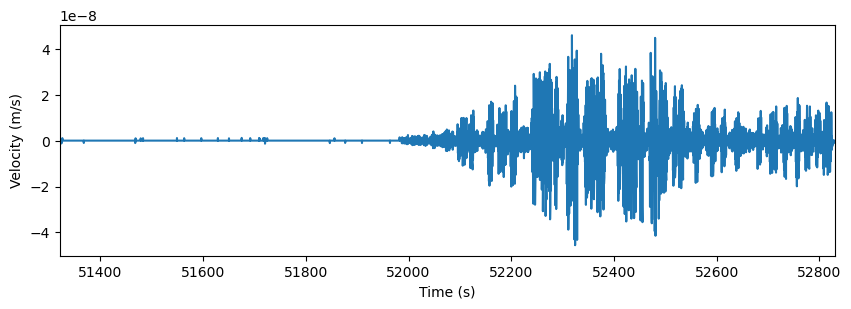

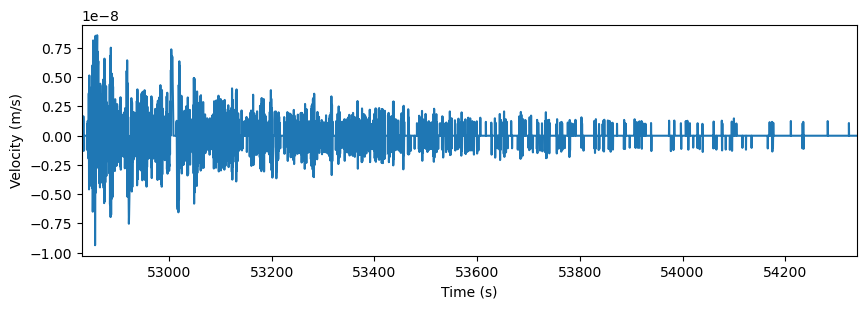

In [525]:
def plot_chunk(chunk):
    csv_times = np.array(chunk["time_rel(sec)"].tolist())
    csv_velocities = np.array(chunk["velocity(m/s)"].tolist())

    # Plot the trace!
    fig,ax = plt.subplots(1,1,figsize=(10,3))
    ax.plot(csv_times,csv_velocities)
    # Make the plot pretty
    ax.set_xlim([min(csv_times),max(csv_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')

for index in indices_of_ones:
    chunk_plot = chuncks_testing_df["chunks"].values[index]
    plot_chunk(chunk_plot)

Whole Data Set

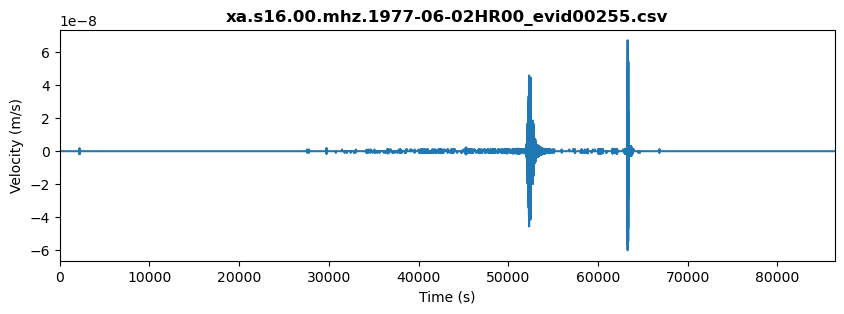

In [526]:
plot_data(raw_data_dir, file_name)